In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, roc_auc_score, auc

In [2]:
import Models

In [3]:
df = pd.read_csv('C:/Users/cheryl/Downloads/df_for_model.csv', encoding='latin-1')

In [4]:
embedded_cols = ["Job Title_embed","Profile_embed","Department_embed","Job_Description_embed","Requirements_embed",
                "Job_Benefits_embed","Type_of_Industry_embed","Operations_embed","City_embed"]
categorical_feats = ["Qualification_bachelor's degree", "Salary_Specified", "Type_of_Employment_unspecified",
                     "Qualification_high school", "City_Specified", "Experience_entry level","Qualification_master's degree",
                     "Experience_unspecified", "Telecomunication","Qualification_vocational / certification/ professional",
                     "Experience_midsenior level", "Qualification_unspecified", "Type_of_Employment_fulltime"]

In [5]:
for col in embedded_cols:
    df[col] = df[col].apply(Models.convert_to_array)

In [6]:
X = Models.flatten(df)

## PCA

In [13]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

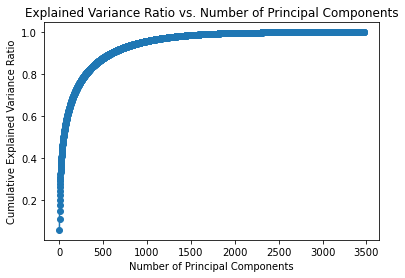

In [15]:
X_pca = Models.do_pca(X_std)

In [16]:
pca = PCA(n_components = 100)
X_pca = pca.fit_transform(X_std)
explained_variance = pca.explained_variance_ratio_
variance_first_100 = explained_variance.sum()
print(f"Variance explained by first 100 components: {variance_first_100:.3f}")

Variance explained by first 100 components: 0.618


## Train-Test Split

In [17]:
df1 = pd.DataFrame(X_pca)
y = df['Fraudulent']
X_train, X_test, y_train, y_test = train_test_split(df1, y, test_size = 0.2, random_state = 4263)
print(X_train.shape) 
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8524, 100)
(2132, 100)
(8524,)
(2132,)


In [18]:
print("Counts of label '1' in training data: {}".format(sum(y_train == 1)))
print("Counts of label '0' in training data: {}".format(sum(y_train == 0)))

Counts of label '1' in training data: 588
Counts of label '0' in training data: 7936


## Resampling

In [19]:
X_train_balanced, y_train_balanced = Models.resampling_method('Oversampling',X_train,y_train)

Resampled class counts:
0    7936
1    7936
Name: Fraudulent, dtype: int64


## Logistic regression (without tuning)

In [20]:
logistic_model = LogisticRegression(solver='liblinear',random_state = 4263)

logistic_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = logistic_model.predict(X_test)

Accuracy: 0.900562851782364
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1990
           1       0.39      0.87      0.54       142

    accuracy                           0.90      2132
   macro avg       0.69      0.89      0.74      2132
weighted avg       0.95      0.90      0.92      2132



array([[1796,  194],
       [  18,  124]], dtype=int64)

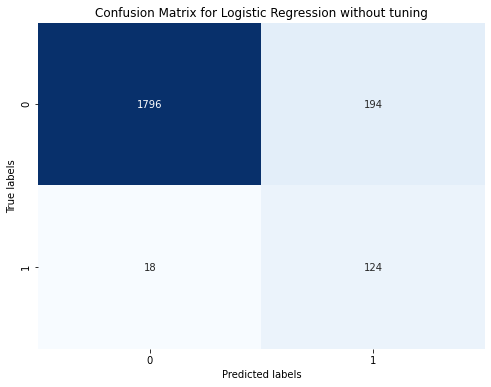

In [21]:
Models.evaluate_model(y_test,y_pred,'Logistic Regression without tuning')

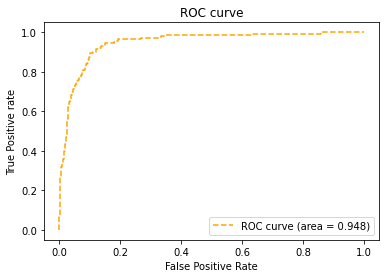

AUC score: 0.948


In [22]:
Models.auc_roc(logistic_model,'Logistic Regression without tuning',X_test,y_test)

## Logistic regression (with tuning)

In [23]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2']  # L1 (Lasso) or L2 (Ridge) regularization
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(logistic_model, 
                           param_grid, 
                           cv=5, 
                           scoring= ['precision','recall'],
                           refit = 'recall',
                           n_jobs=-1)
grid_search.fit(X_train_balanced, y_train_balanced)

# Print the best parameters and corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Best Accuracy: 0.9372472180293601
Test Accuracy: 0.8888367729831145


Accuracy: 0.8888367729831145
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1990
           1       0.36      0.89      0.52       142

    accuracy                           0.89      2132
   macro avg       0.68      0.89      0.73      2132
weighted avg       0.95      0.89      0.91      2132



array([[1768,  222],
       [  15,  127]], dtype=int64)

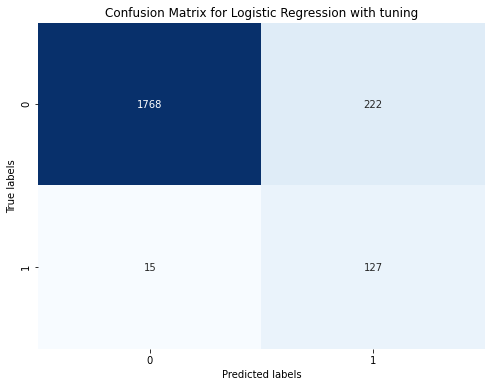

In [24]:
Models.evaluate_model(y_test,y_pred,'Logistic Regression with tuning')

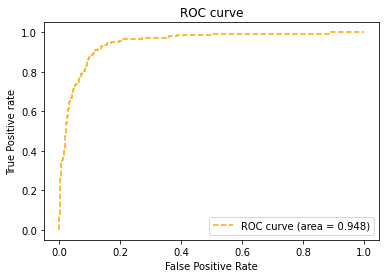

AUC score: 0.948


In [25]:
Models.auc_roc(best_model,'Logistic Regression with tuning',X_test,y_test)

## Random Forest (without tuning)

In [26]:
rfc = RandomForestClassifier(random_state = 4263)
rfc.fit(X_train_balanced, y_train_balanced)
y_pred = rfc.predict(X_test)

Accuracy: 0.9666979362101313
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1990
           1       0.99      0.51      0.67       142

    accuracy                           0.97      2132
   macro avg       0.98      0.75      0.83      2132
weighted avg       0.97      0.97      0.96      2132



array([[1989,    1],
       [  70,   72]], dtype=int64)

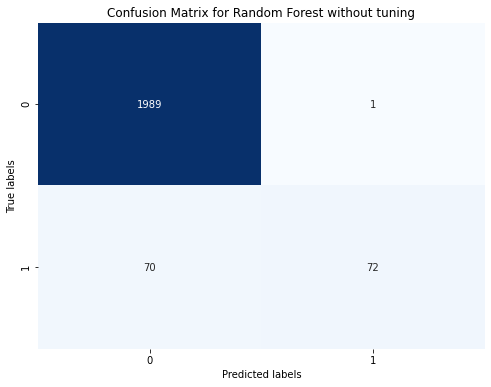

In [27]:
Models.evaluate_model(y_test,y_pred,'Random Forest without tuning')

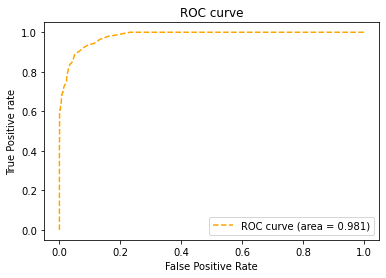

AUC score: 0.981


In [28]:
Models.auc_roc(rfc,'Random Forest without tuning',X_test,y_test)

## Random Forest (with tuning)

In [62]:
rfc = RandomForestClassifier(random_state = 4263, 
                             max_features = 'sqrt',
                             n_estimators= 50,
                             max_depth = 9, 
                             criterion = 'gini',
                             n_jobs=-1)
rfc.fit(X_train_balanced, y_train_balanced)
y_pred = rfc.predict(X_test)

Accuracy: 0.9648217636022514
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1990
           1       0.75      0.71      0.73       142

    accuracy                           0.96      2132
   macro avg       0.86      0.85      0.86      2132
weighted avg       0.96      0.96      0.96      2132



array([[1956,   34],
       [  41,  101]], dtype=int64)

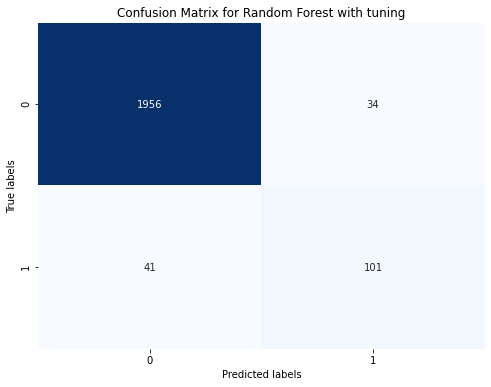

In [63]:
Models.evaluate_model(y_test,y_pred,'Random Forest with tuning')

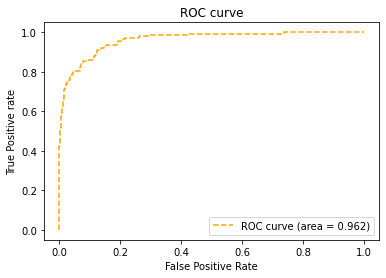

AUC score: 0.962


In [64]:
Models.auc_roc(rfc,'Random Forest with tuning',X_test,y_test)

## Neural Networks

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
num_features = X_train_balanced.shape[1]
print(num_features)

In [ ]:
# Build the model
nn_model = Sequential([
    Input(shape=(num_features,)),  # Input layer
    Dense(128, activation='relu'), # First hidden layer
    Dense(64, activation='relu'),  # Second hidden layer
    Dense(32, activation='relu'),  # Third hidden layer
    Dense(1, activation='sigmoid') # Output layer (binary classification)
])
optimizer = Adam(learning_rate=0.001)  
nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Recall()])

# Print model summary
nn_model.summary()

In [ ]:
nn_model.fit(X_train_balanced,
             y_train_balanced,
             epochs=10, 
             batch_size=32,
             validation_data=(X_test, y_test))

In [ ]:
results = nn_model.evaluate(X_test, y_test)
accuracy = results[1]
recall = results[2]
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Recall: {recall:.4f}")

In [ ]:
y_pred = nn_model.predict(X_test)
y_pred = np.round(y_pred).tolist()

In [ ]:
Models.evaluate_model(y_test,y_pred,'Neural Network')